训练自编码器

用现在筛选过的数据训练自编码器

数据选用包含丢帧及不完整的数据

纯 MLP


---


In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter


from model.PIAE_models import T7DAE2,Vehicle_Model_Methods

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


显卡参与训练


In [2]:


# 1. 加载预处理后的数据
def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task4_data'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_noisy_lost_data1.kpl'))
dataset = TensorDataset(tarin_data[1],tarin_data[0],tarin_data[4]) # 使用轨迹点掩码
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)


val_data = load_preprocessed_data(os.path.join(input_file,'val_noisy_lost_data1.kpl'))
val_input = val_data[1].to(device)
val_label = val_data[0].to(device)
val_mask = val_data[4].to(device)

In [3]:
# 3. 定义模型、损失函数和优化器
model = T7DAE2()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

T7DAE2(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40, out_features=400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=40, bias=True)
    (3): Unflatten(dim=1, unflattened_size=(2, 20))
  )
)

In [4]:
# 4. 训练模型Autoencoder


# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log13')


epochs = 300
best_loss = float('inf')

for epoch in range(epochs):
    for batch_idx, (inputs,label,mask) in enumerate(dataloader):  
        # 添加噪声
        inputs = inputs.to(device)  # 将输入数据移动到同一设备
        label = label.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        outputs = model(inputs* mask)
        # print('output shape:',outputs.shape)

        outputs_mask = outputs * mask
        label_mask = label * mask
        loss = criterion(outputs_mask, label_mask)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}')

    with torch.no_grad():
        
        val_out = model(val_input* val_mask)
        val_out_mask = val_out * val_mask
        val_label_mask = val_label * val_mask

        loss_val = criterion(val_out_mask, val_label_mask)
        orig_err = criterion(val_input, val_label_mask)
    
    print(f'验证集上的指标为:{loss_val}，总噪声为:{orig_err},减少噪声{orig_err-loss_val}')
    
    if loss_val.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task13_t7dae2_lost.pth')
        best_loss = loss_val.item()

    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', loss_val, epoch)

# 关闭SummaryWriter
writer.close()




Epoch 1, Train Loss: 0.007545276079326868
验证集上的指标为:0.009760302491486073，总噪声为:0.5178446173667908,减少噪声0.5080842971801758
Epoch 2, Train Loss: 0.01048704981803894
验证集上的指标为:0.015537076629698277，总噪声为:0.5178446173667908,减少噪声0.5023075342178345
Epoch 3, Train Loss: 0.005177511367946863
验证集上的指标为:0.007383971009403467，总噪声为:0.5178446173667908,减少噪声0.5104606747627258
Epoch 4, Train Loss: 0.005102830473333597
验证集上的指标为:0.0061643547378480434，总噪声为:0.5178446173667908,减少噪声0.5116802453994751
Epoch 5, Train Loss: 0.00932630617171526
验证集上的指标为:0.01158911269158125，总噪声为:0.5178446173667908,减少噪声0.5062555074691772
Epoch 6, Train Loss: 0.005340242292732
验证集上的指标为:0.006395823787897825，总噪声为:0.5178446173667908,减少噪声0.5114488005638123
Epoch 7, Train Loss: 0.0059808408841490746
验证集上的指标为:0.006801223382353783，总噪声为:0.5178446173667908,减少噪声0.51104336977005
Epoch 8, Train Loss: 0.00481907045468688
验证集上的指标为:0.006361581850796938，总噪声为:0.5178446173667908,减少噪声0.5114830136299133
Epoch 9, Train Loss: 0.009016093797981739
验证集上的指标为:0.00

验证集上的指标为:0.0045085325837135315，总噪声为:0.5178446173667908,减少噪声0.5133360624313354
9781


<Figure size 1000x700 with 0 Axes>

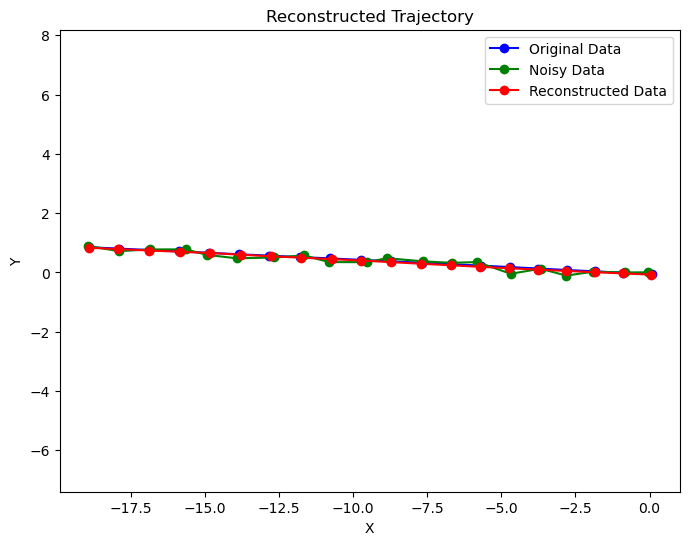

In [42]:
# model = T7DAE2()
# model.to(device)

model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task13_t7dae2_lost.pth',weights_only=True))

import numpy as np

model.eval()

with torch.no_grad():
    val_out = model(val_input* val_mask)
    val_out_mask = val_out * val_mask
    val_label_mask = val_label * val_mask

    loss_val = criterion(val_out_mask, val_label_mask)
    orig_err = criterion(val_input, val_label_mask)
print(f'验证集上的指标为:{loss_val}，总噪声为:{orig_err},减少噪声{orig_err-loss_val}')

# 6. 绘制原始轨迹和重建后的轨迹
plt.figure(figsize=(10, 7))

# 绘制原始轨迹
# num = num-1
num = np.random.randint(60000)
print(num)
plt.figure(figsize=[8,6])
plt.plot(val_label.cpu().numpy()[num,:,0], val_label.cpu().numpy()[num,:,1], '-o',c='blue', label='Original Data')
plt.plot(val_input.cpu().numpy()[num,:,0], val_input.cpu().numpy()[num,:,1], '-o', c='green', label='Noisy Data')
plt.plot(val_out.cpu().numpy()[num,:,0], val_out.cpu().numpy()[num,:,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

In [6]:
# 计算突破约束比例

# 定义临时类
# 创建一个临时类并继承 MyMixin
class TempClass(Vehicle_Model_Methods):
    pass

# 实例化临时类
temp_instance = TempClass()
ax_out_rate,delta_out_rate,traj_out_rate=temp_instance.constrain_count(val_out,10,0.25)
print('加速度突破率：',ax_out_rate)
print('转向突破率：',delta_out_rate)
print('轨迹突破率：',traj_out_rate)

加速度突破率： 0.13779747486114502
转向突破率： 0.12441208213567734
轨迹突破率： 0.4345892071723938


In [7]:
# 计算原始数据和噪声数据

print('噪声数据')
ax_out_rate,delta_out_rate,traj_out_rate=temp_instance.constrain_count(val_input,10,0.25)
print('加速度突破率：',ax_out_rate)
print('转向突破率：',delta_out_rate)
print('轨迹突破率：',traj_out_rate)


print('\n原始数据')
ax_out_rate,delta_out_rate,traj_out_rate=temp_instance.constrain_count(val_label,10,0.25)
print('加速度突破率：',ax_out_rate)
print('转向突破率：',delta_out_rate)
print('轨迹突破率：',traj_out_rate)

噪声数据
加速度突破率： 0.5768613815307617
转向突破率： 0.4555371105670929
轨迹突破率： 0.9965173602104187

原始数据
加速度突破率： 0.029488330706954002
转向突破率： 0.01897525228559971
轨迹突破率： 0.18869715929031372


In [8]:
# 计算误差
def ADE_err(out,label):
    if isinstance(out, np.ndarray):
        out = torch.tensor(out, dtype=torch.float32)  # 将numpy.ndarray转换为Tensor
    ade = ((out - label) ** 2).sum(axis=2).sqrt().mean()
    return ade.item()

print('轨迹重构误差：',ADE_err(val_out,val_label))

轨迹重构误差： 0.8555588126182556
